# Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt  
import pandas as pd
import numpy as np
import os, sys, pdb
import torch, torchvision
from torch import nn
import pickle
import time
from PIL import Image
import math
import seaborn as sns

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

sys.path.insert(0,'/jet/home/nmurali/asc170022p/nmurali/projects/misc/TMLR23_Dynamics_of_Spurious_Features/scripts')
import models, datasets

# Utility Functions and Classes

In [3]:
class center_crop(object):
    def crop_center(self, img):
        _, y, x = img.shape
        crop_size = np.min([y,x])
        startx = x // 2 - (crop_size // 2)
        starty = y // 2 - (crop_size // 2)
        return img[:, starty:starty + crop_size, startx:startx + crop_size]
    
    def __call__(self, img):
        return self.crop_center(img)

class normalize(object):
    def normalize_(self, img, maxval=255):
        img = (img)/(maxval)
        return img
    
    def __call__(self, img):
        return self.normalize_(img)
    
# takes in a list of img paths and plots grid of images
def plot_images(img_list, rows, cols, grayscale=False, titles=None):
    plt.figure(figsize=(7.5*cols,7.5*rows))
    for i in range(rows*cols):
        plt.subplot(rows,cols,i+1)
        if type(img_list[0])==str:
            img = plt.imread(img_list[i])
        else:
            img = img_list[i]
        if grayscale:
            img = torch.tensor(img)
            img = img.unsqueeze(-1)
            img = torch.cat([img,img,img],-1)
        plt.imshow(img)
        if titles is not None:
            plt.title(titles[i])
    plt.show()

# Plot PD Histogram

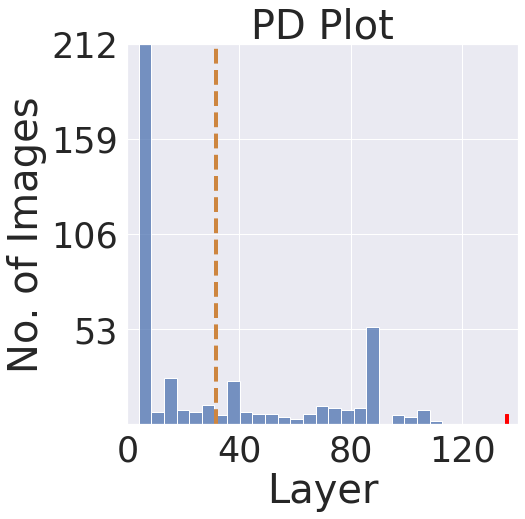

In [4]:
pd_pkl_file = '/jet/home/nmurali/asc170022p/nmurali/projects/shortcut_detection_and_mitigation/experiments/medical_expts/github_covid/github_covid_test_pd.pkl' # this comes from the output of ./scripts/analyse_ckpt.py

with open(pd_pkl_file, 'rb') as handle:
    batch_info = pickle.load(handle)

batch_info['pd'] = np.array(batch_info['pd'])
batch_info['labels'] = np.array(batch_info['labels'])
batch_info['preds'] = np.array(batch_info['preds'])

pos_pd_arr = (batch_info['pd']>=0)
batch_info['pd'][~pos_pd_arr] = 140 # undefined samples are assigned a pd of 140 (just for visualization purposes)
pd_mean = np.mean(batch_info['pd'][pos_pd_arr&(batch_info['pd']<=120)])
correct_preds_arr = (batch_info['preds']==batch_info['labels'])
y_lim = np.bincount(batch_info['pd']).max() 
y_step = math.ceil(y_lim/4)

sns.set(style="darkgrid")
plt.figure(figsize=(7,7))
plt.title(f'PD Plot', fontsize=40)
plt.ylabel('No. of Images', fontsize=40)
plt.xlabel('Layer', fontsize=40)
plt.xlim((0,140))
plt.ylim((0,y_lim))
plt.xticks([0,40,80,120], fontsize=35)
plt.yticks([y_step,y_step*2,y_step*3,y_step*4], fontsize=35)

sns_hist = sns.histplot(batch_info['pd'],bins=30)
sns_hist.vlines(pd_mean,0,y_lim,color='peru',linestyle='dashed',linewidth=4)
sns_hist.get_children()[29].set_color("red")
sns_hist.get_children()[29].set_width(1)

# Images of interest

In [27]:
# user hyperparams
img_pd = 4
img_labels = 1
correct_preds = True

if correct_preds:
    mask_arr = ((batch_info['pd']==img_pd) & (batch_info['labels']==img_labels) & correct_preds_arr) # define your mask
else:
    mask_arr = ((batch_info['pd']==img_pd) & (batch_info['labels']==img_labels) & ~correct_preds_arr) # define your mask
batch_info['paths'] = np.array(batch_info['paths'])
img_paths = list(batch_info['paths'][mask_arr])
len(img_paths)

58

# Viz Peaks

In [28]:
# user hyperparams
viz_pd = 4 # which densenet-layer to viz (although images may have different pd)
grayscale = False
imgsize = 128 
embs_path = '/jet/home/nmurali/asc170022p/nmurali/projects/shortcut_detection_and_mitigation/experiments/medical_expts/github_covid/github_covid_subset_embs.pkl' # comes from the output of ./scripts/analyse_ckpt.py
ckpt_path = '/jet/home/nmurali/asc170022p/nmurali/projects/shortcut_detection_and_mitigation/experiments/medical_expts/github_covid/github_covid_512_best_auc0.9828.pt'

In [29]:
if grayscale: # mainly for GithubCovid
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize((img_size,img_size)),
        torchvision.transforms.Grayscale(num_output_channels=1),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Lambda(center_crop()),
        torchvision.transforms.Lambda(normalize())
    ])
else: # for nih, mimic, chexpert
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize((imgsize,imgsize)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Lambda(center_crop()),
        torchvision.transforms.Lambda(normalize())
    ])

In [30]:
# GradCAM on intermediate soft-KNN outputs

# load model
model = models.customDenseNet(embs_path, viz_pd, num_classes=1, in_channels=1, drop_rate=0.0,**models.get_densenet_params('densenet121')) 
model.load_state_dict(torch.load(ckpt_path).state_dict())
model.eval()

XRV-DenseNet

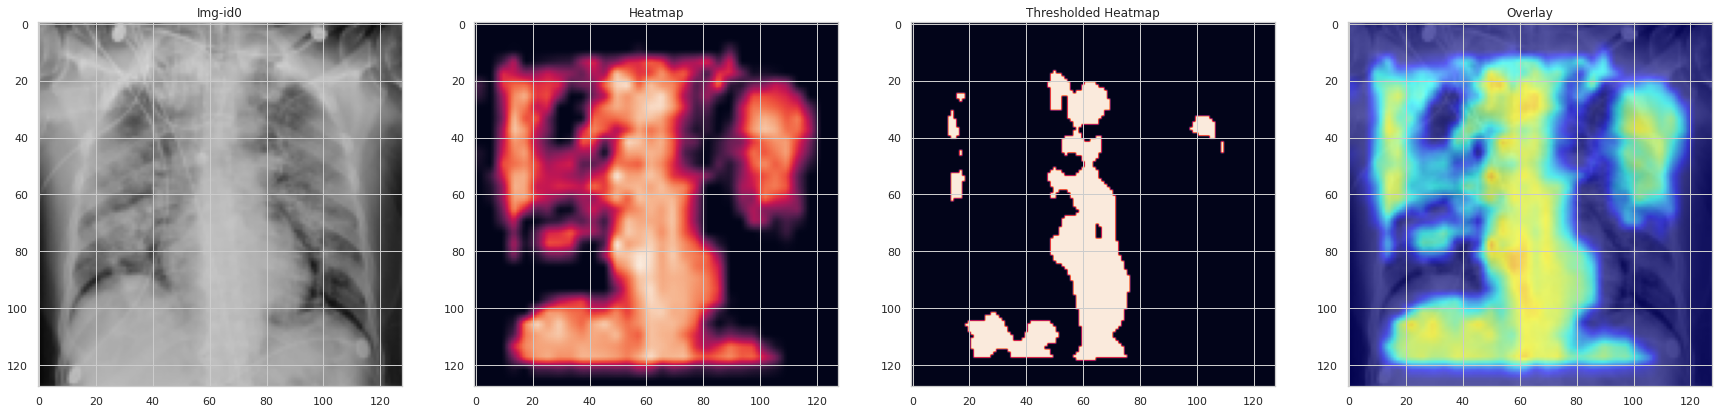

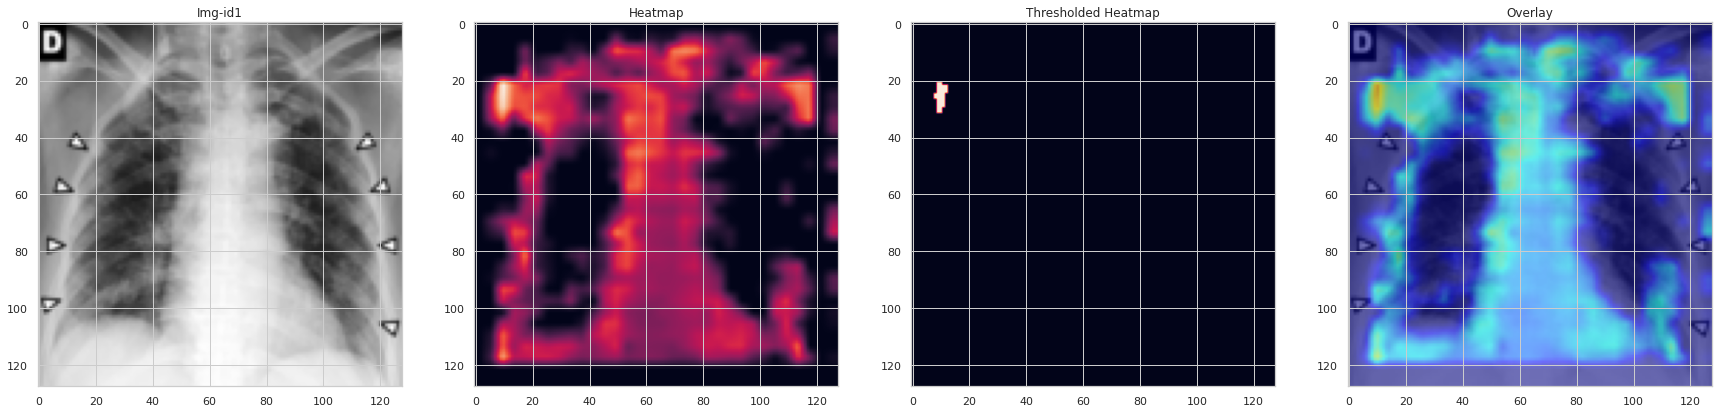

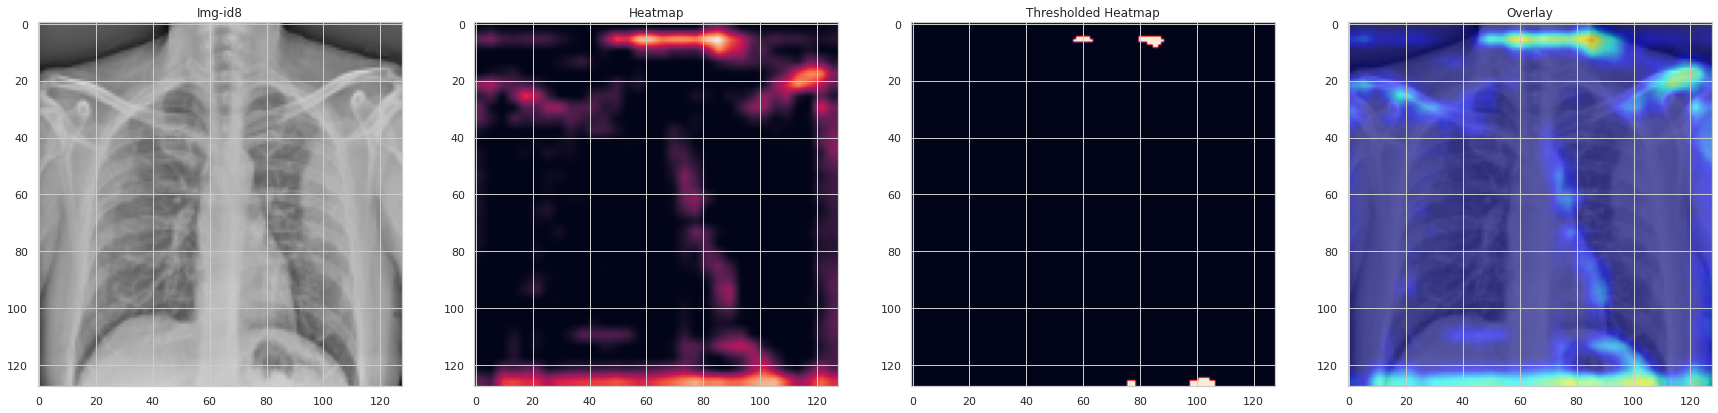

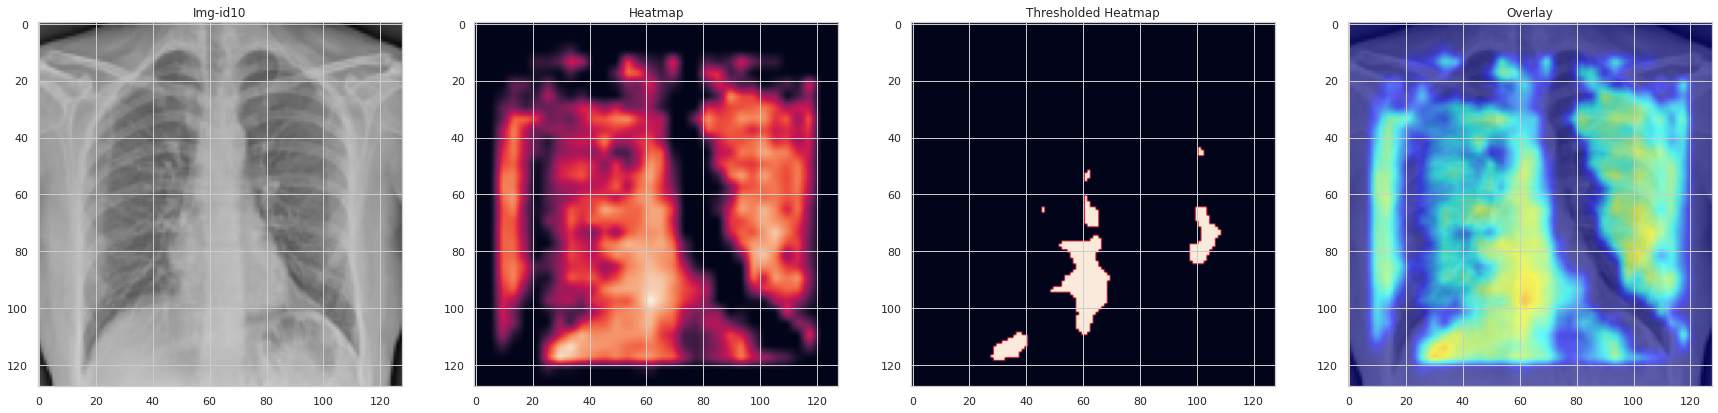

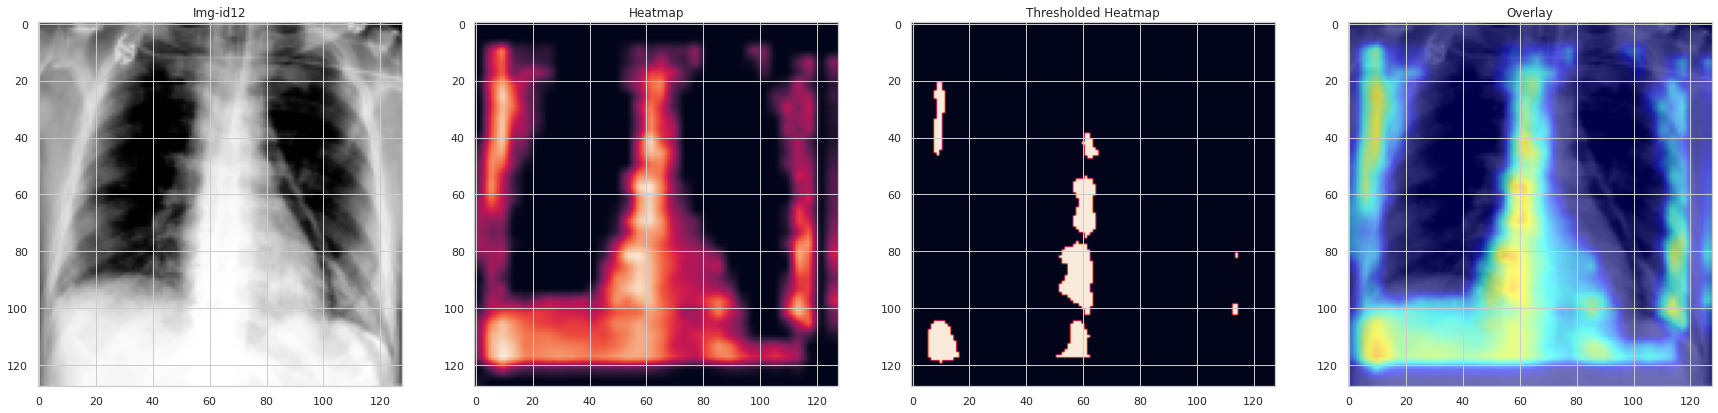

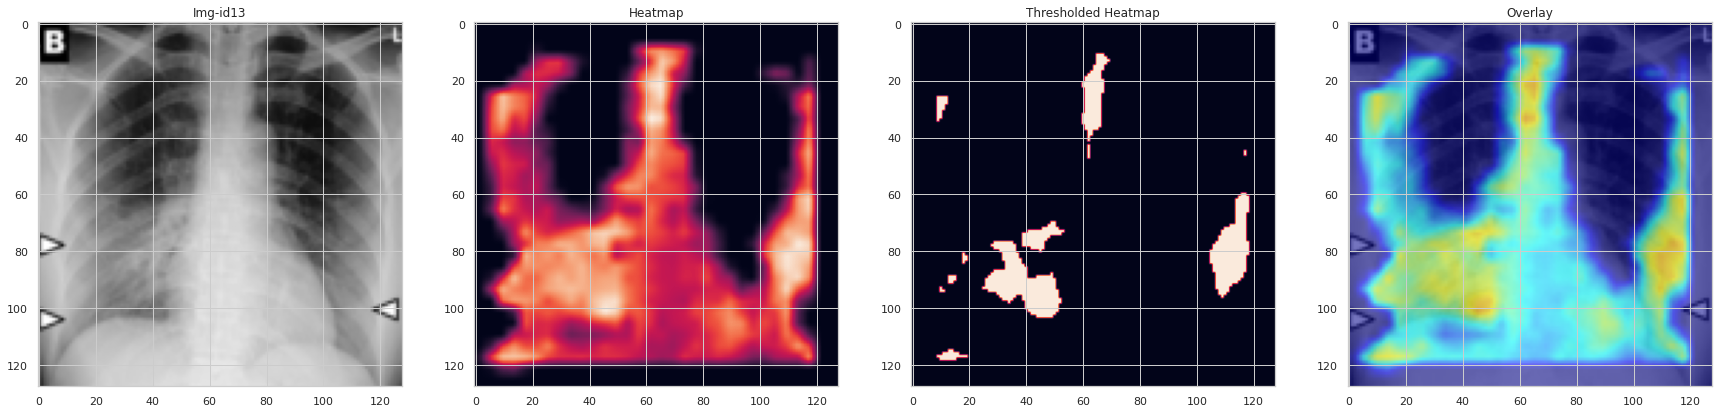

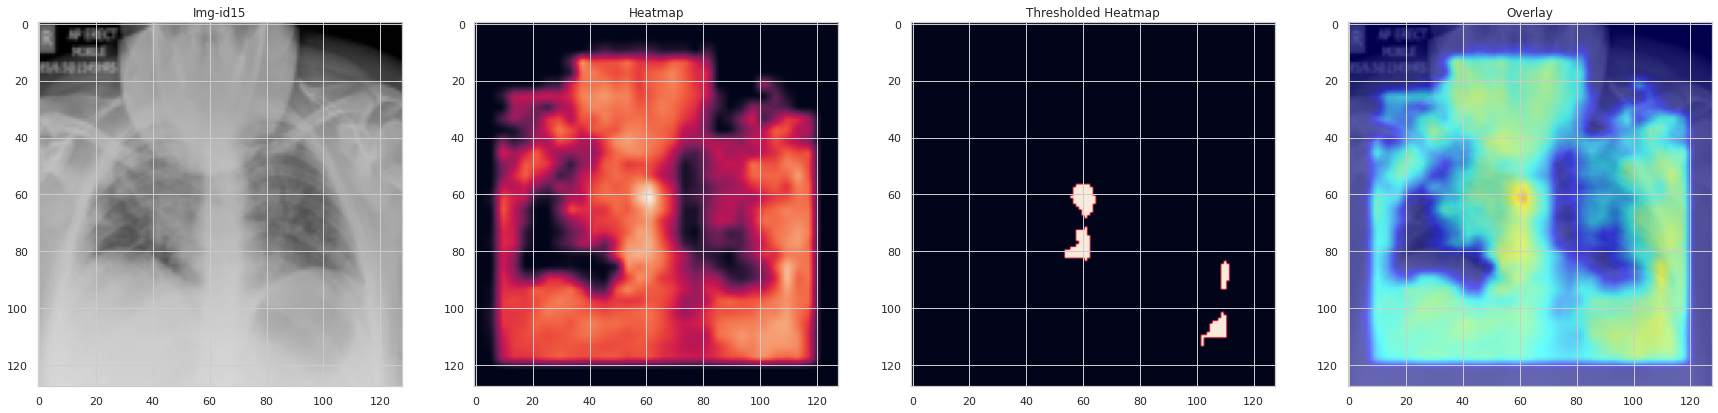

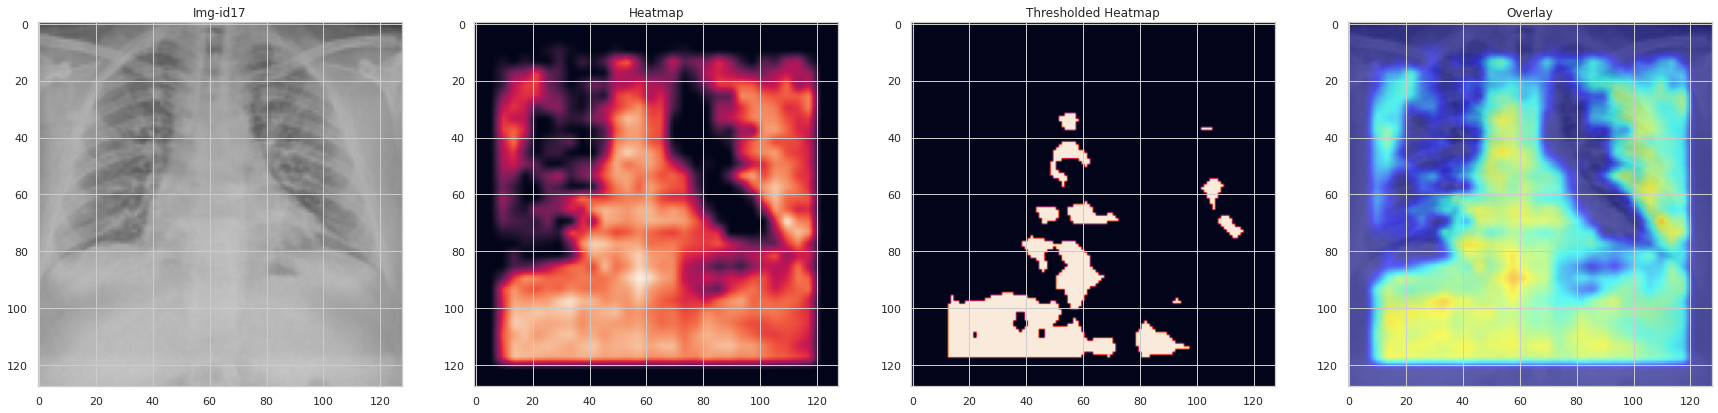

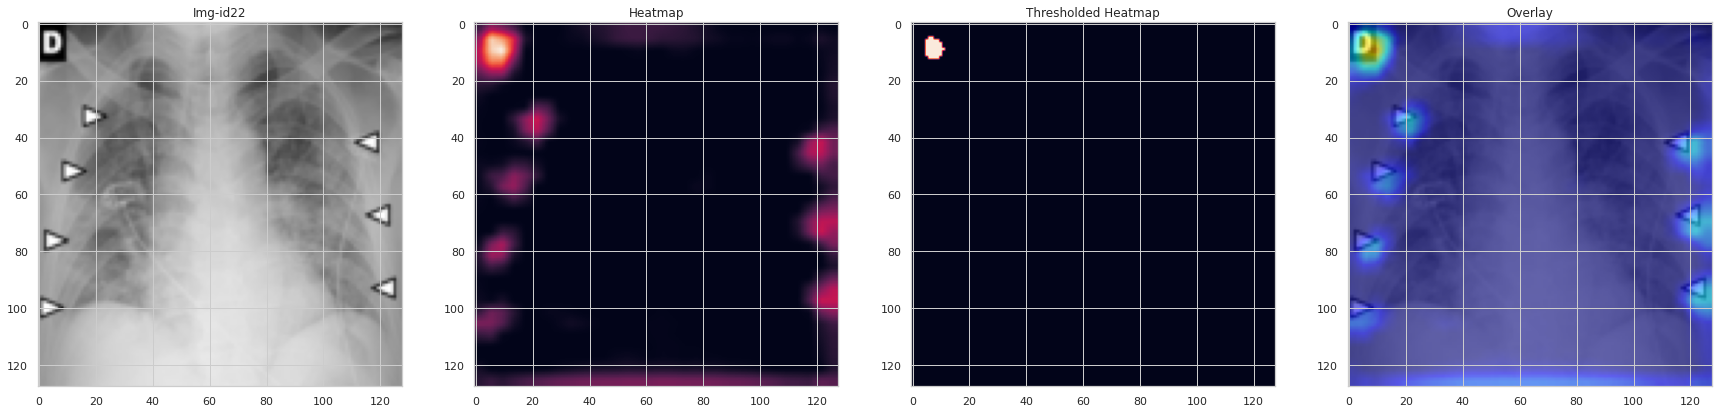

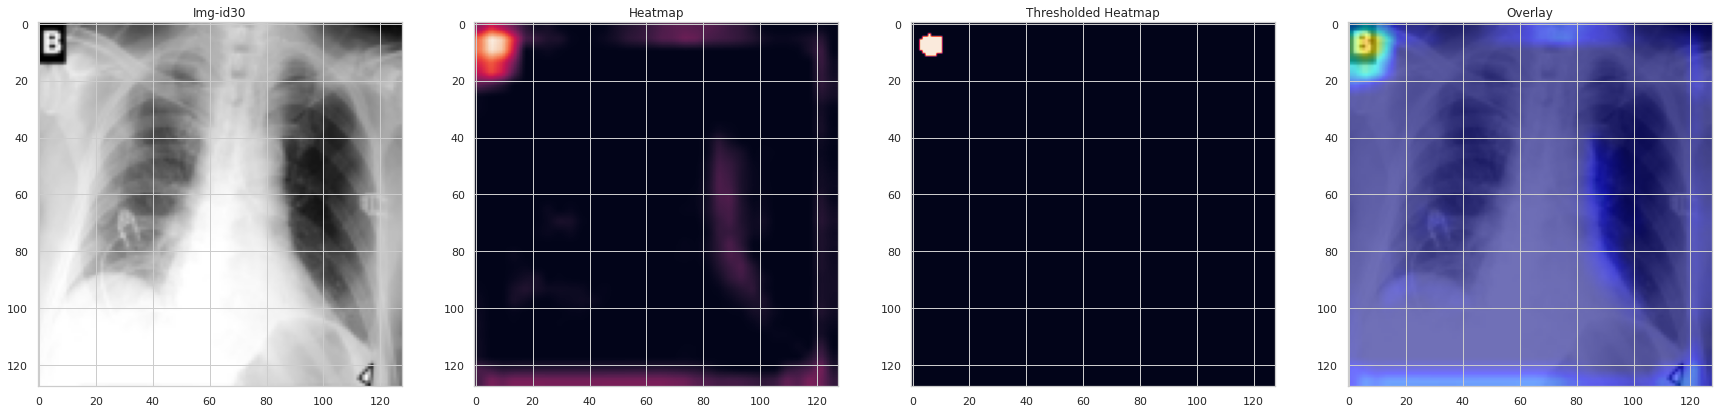

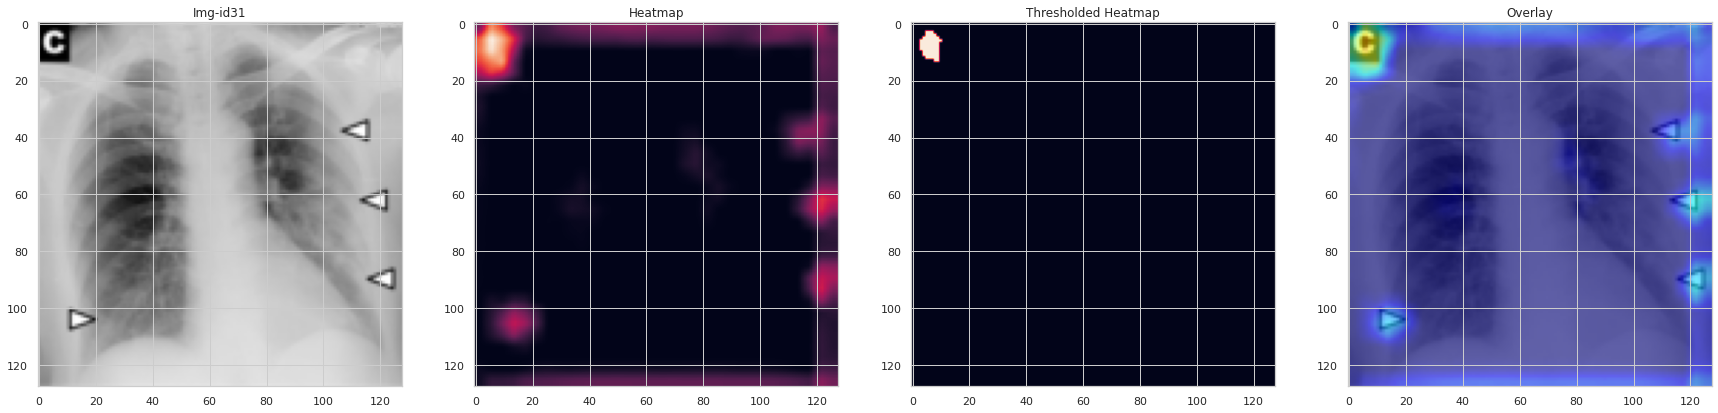

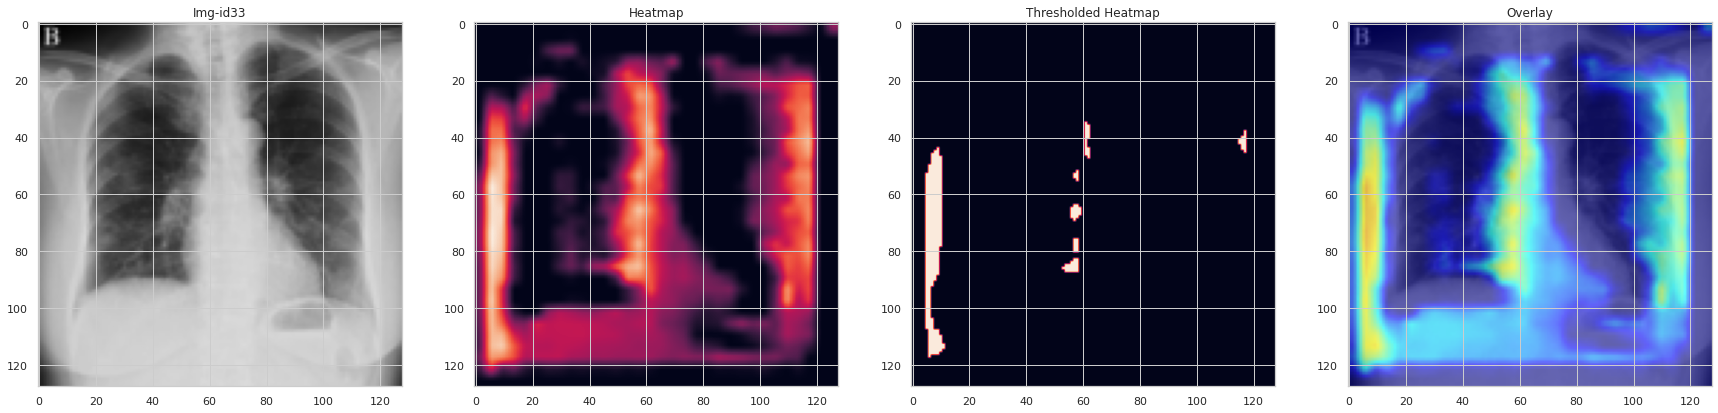

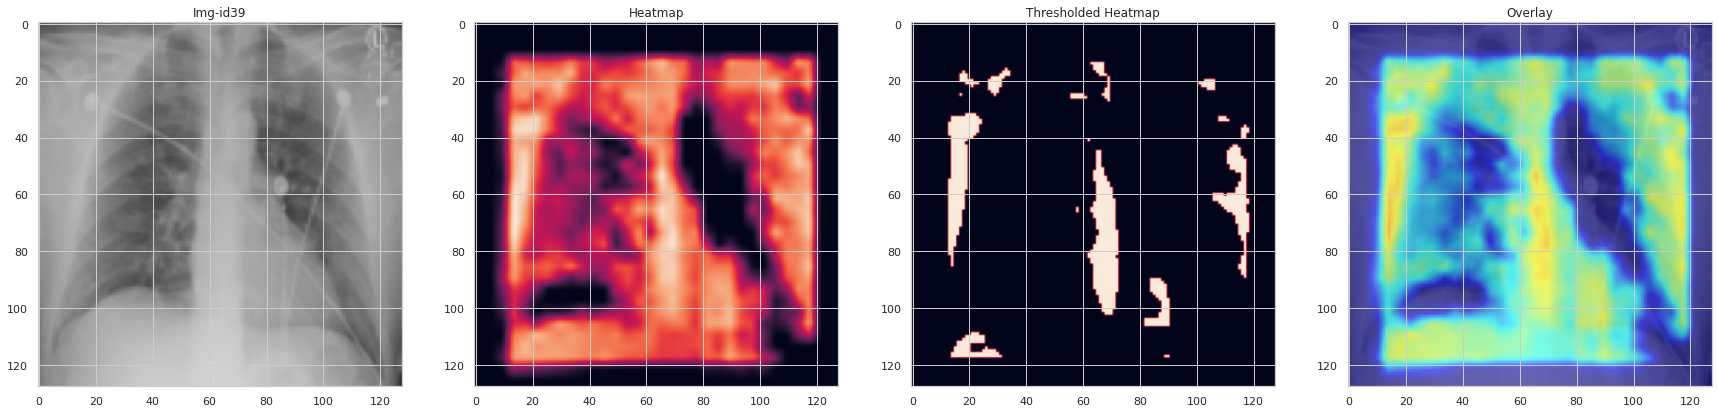

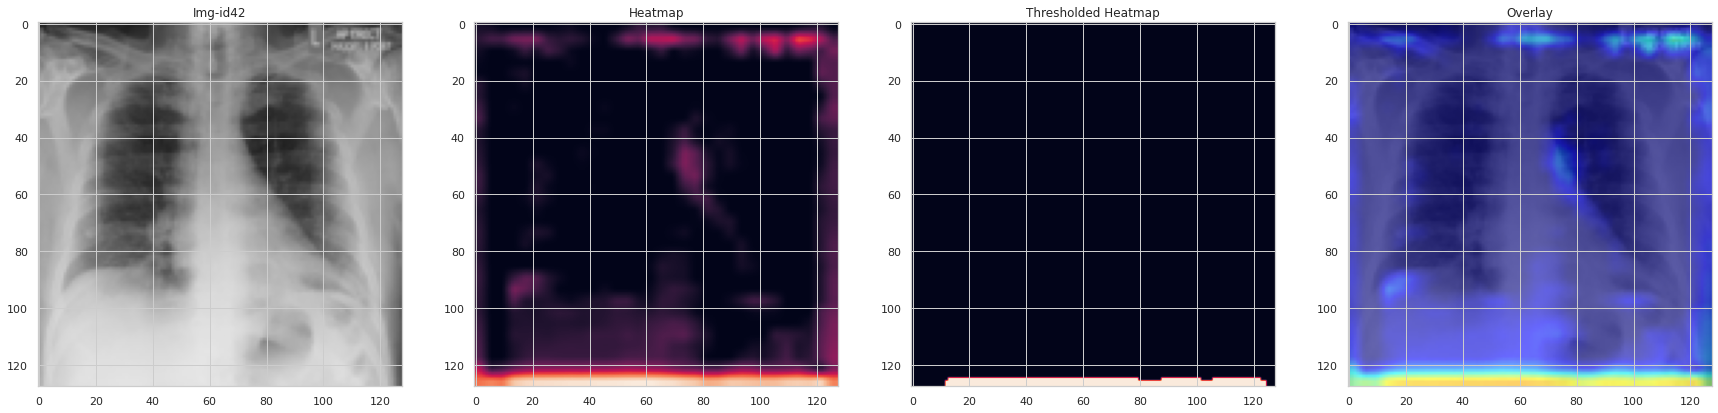

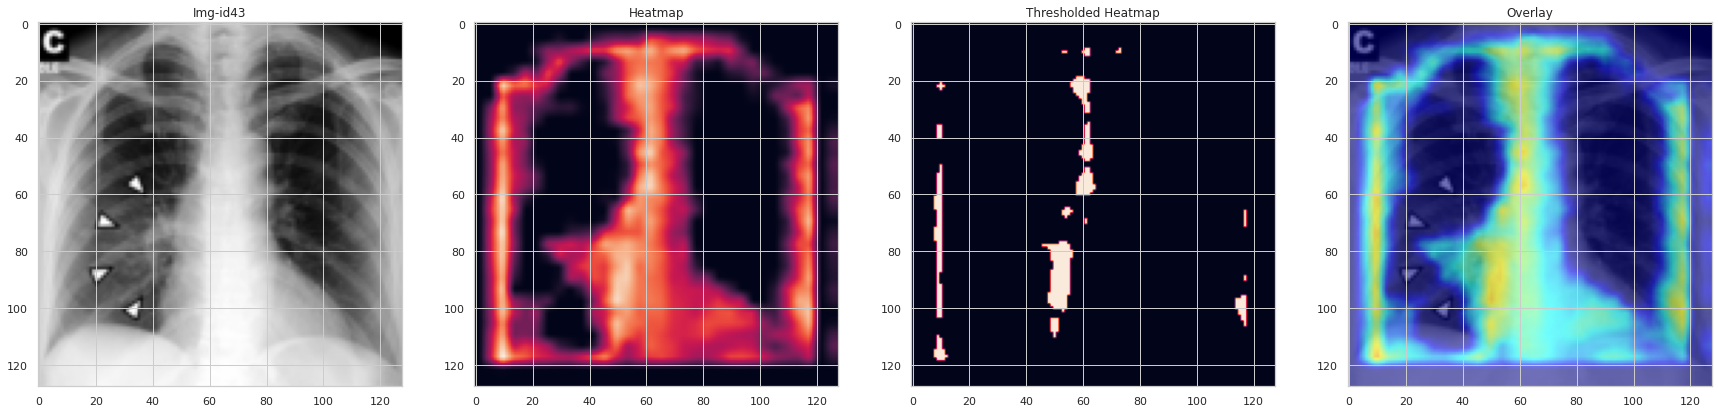

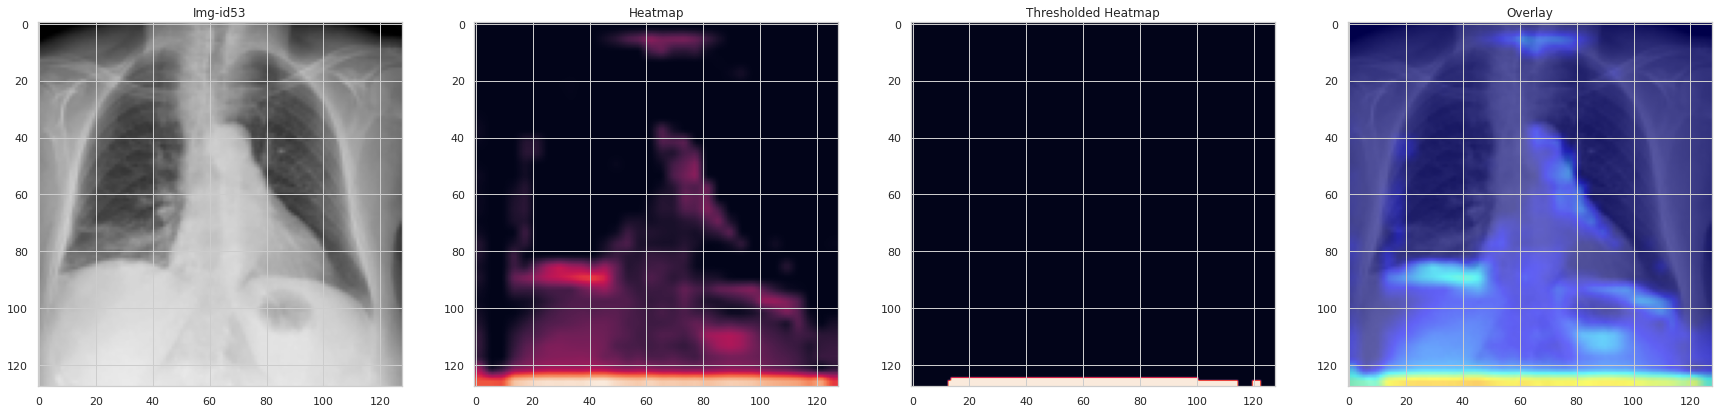

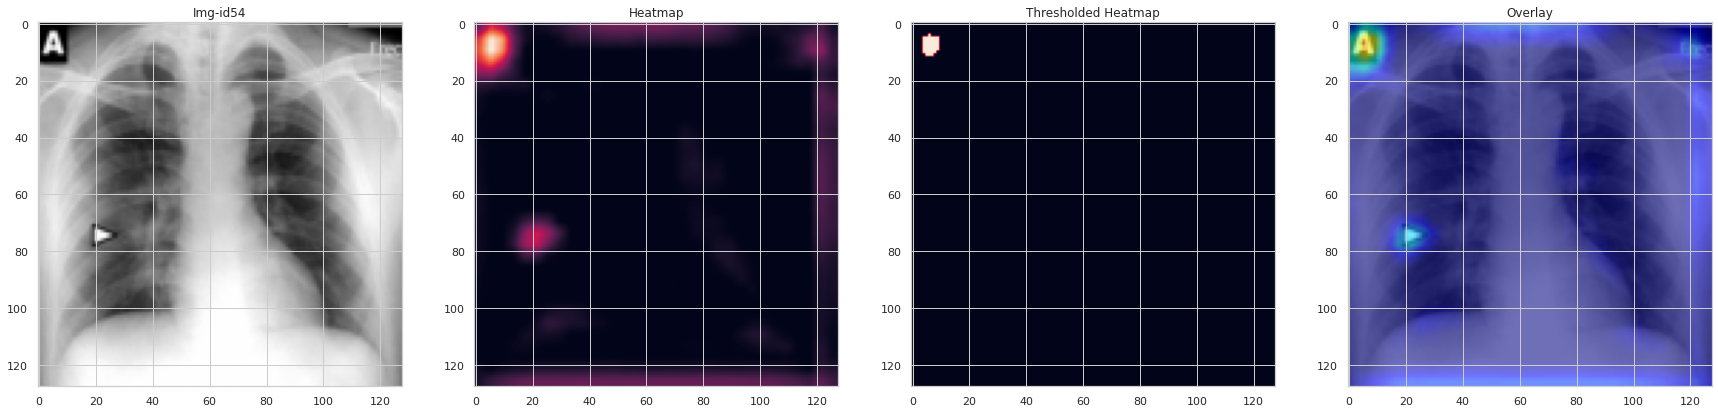

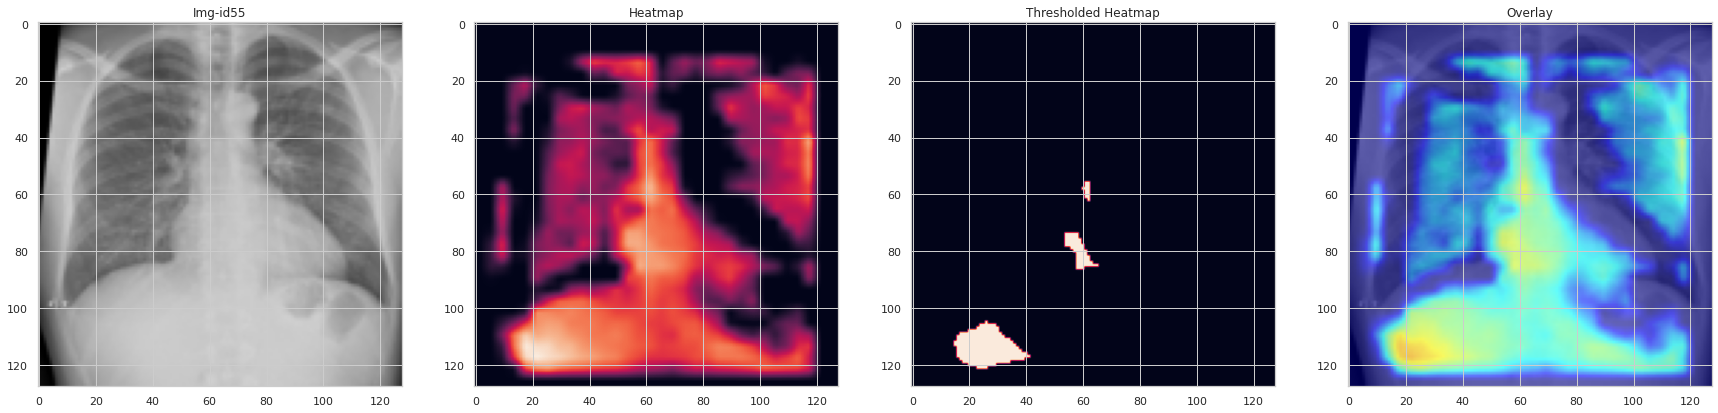

In [31]:
sns.set(style="whitegrid")
for img_id,img_path in enumerate(img_paths):
    try:
        with Image.open(img_path) as img:
            img = transforms(img).unsqueeze(0).to('cuda')
            if img.shape[1]==4:
                img = img[:,0,:,:].unsqueeze(0)

            # gradCAM code
            targets = [ClassifierOutputTarget(0)]
            if viz_pd/4>=1 and viz_pd/4<=3:
                denselayer = int(1 + 2*(viz_pd/4-1))
                target_layers = [model.features.denseblock1[denselayer-1]]

            elif viz_pd/4>=4 and viz_pd/4<=9:
                denselayer = int(1 + 2*(viz_pd/4-4))
                target_layers = [model.features.denseblock2[denselayer-1]]

            elif viz_pd/4>=10 and viz_pd/4<=21:
                denselayer = int(1 + 2*(viz_pd/4-10))
                target_layers = [model.features.denseblock3[denselayer-1]]

            else:
                denselayer = int(1 + 2*(viz_pd/4-22))
                target_layers = [model.features.denseblock4[denselayer-1]]

            cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
            grayscale_cams = cam(input_tensor=img, targets=targets, aug_smooth=False, eigen_smooth=True)
            img = img.squeeze().unsqueeze(-1)
            img = torch.cat((img,img,img),dim=2).detach().cpu()
    #         cam_op = show_cam_on_image(np.array(img)*200, (grayscale_cams[0]>0.5).astype(float)*0.7, use_rgb=True)
            cam_op = show_cam_on_image(np.array(img)*200, grayscale_cams[0]*0.7, use_rgb=True)

            img_list = []
            img_list.append(img*255)
            img_list.append(grayscale_cams[0])
            img_list.append((grayscale_cams[0]>0.8).astype(float))
            img_list.append(cam_op)

            # plot results
            plot_images(img_list,rows=1,cols=4,titles=[f'Img-id{img_id}','Heatmap','Thresholded Heatmap','Overlay'])
    #         if img_id==4:
    #             break
    except:
        pass